In [4]:
%matplotlib inline

from __future__ import print_function, division

# Author: Xiang Wang

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader, sampler


import torchvision
from torchvision import datasets, models, transforms, models

from tensorboardX import SummaryWriter

import numpy as np
import time
import os
import copy
import pickle

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plt.ion()   # interactive mode

## 一、数据加载与处理

### 1. 使用pytorch的内置的函数读入

In [6]:
print('==> Preparing data..')

# Data ToTensor and normalization for training
data_transforms = transforms.Compose([transforms.ToTensor(), 
                                      transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                                     ])


==> Preparing data..


In [93]:
# load dataset

# 使用datasets.CIFAR10加载图片
image_datasets = datasets.MNIST('D:/4.Data/mnist', train=True, download=True, transform=data_transforms)

# 得到可batch的数据格式
data_loaders = DataLoader(image_datasets, batch_size=128, shuffle=True, num_workers=0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [94]:
train_data = data_loaders

In [95]:
# 我们可以看下数据读入和处理后的样子
data, label = image_datasets[0]
print('data_shape: ', data.shape, '\nlabel: ', label)

data_shape:  torch.Size([1, 28, 28]) 
label:  tensor(5)


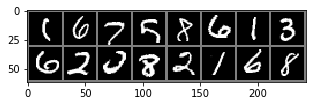

In [96]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.detach().numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_data))
inputs = inputs[0:16]
# Make a grid from batc
out = torchvision.utils.make_grid(inputs)
plt.figure(figsize=(5,5))

imshow(out)

## 二、创建模型

其实GAN的生成器和判别器没有什么出彩的设计，主要是在损失函数上面的构造

### 1. 判别模型

In [97]:
# 就是简单的DNN模型
class gen_D(nn.Module):
    
    def __init__(self, num_classes=10):
        super(gen_D, self).__init__()
        
        self.model_name = 'discriminator'
        
        self.fc = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.LeakyReLU(0.2),
            
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2),
            
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [132]:
D = gen_D()

### 2. 生成模型

In [99]:
class gen_G(nn.Module):
    
    def __init__(self, noise_dim=96):
        super(gen_G, self).__init__()
        
        self.model_name = 'generator'
        
        self.fc = nn.Sequential(
            nn.Linear(noise_dim, 1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.fc(x)
        return x

In [133]:
G = gen_G()

## 三、设置必要的参数

### 1. 损失函数

对于对抗网络，相当于二分类问题，将真的判别为真的，假的判别为假的，作为辅助，可以参考一下论文中公式

$$ \ell_D = \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

而对于生成网络，需要去骗过对抗网络，也就是将假的也判断为真的，作为辅助，可以参考一下论文中公式

$$\ell_G  =  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$

上面这两个公式就是二分类 loss

$$ bce(s, y) = y * \log(s) + (1 - y) * \log(1 - s) $$

In [134]:
# 设置为GPU处理
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
D = D.to(device)
G = G.to(device)

In [135]:
# 二分类交叉熵，不需要手动添加sigmoid
bce_loss = nn.BCEWithLogitsLoss()

In [136]:
# 判别器的损失函数
def discriminator_loss(real_score, fake_score): # 判别器的 loss
    size = real_score.shape[0]
    true_labels = Variable(torch.ones(size, 1)).float().to(device)
    false_labels = Variable(torch.zeros(size, 1)).float().to(device)
    loss = bce_loss(real_score, true_labels) + bce_loss(fake_score, false_labels)
    return loss

In [137]:
# 生成器的损失函数
def generator_loss(fake_score):  
    size = fake_score.shape[0]
    true_labels = Variable(torch.ones(size, 1)).float().to(device)
    loss = bce_loss(fake_score, true_labels)
    return loss

In [138]:
# 使用 adam 来进行训练，学习率是 3e-4, beta1 是 0.5, beta2 是 0.999, 由于这里有两个网络，所以封装成函数的形式来调用
def get_optimizer(net):
    optimizer = torch.optim.Adam(net.parameters(), lr=3e-4, betas=(0.5, 0.999))
    return optimizer

D_optimizer = get_optimizer(D)
G_optimizer = get_optimizer(G)

In [139]:
batch_size = 128
NOISE_DIM =96

## 四、开始训练

In [140]:
def train_model(D, G, discriminator_loss, generator_loss, D_optimizer, G_optimizer, noise_size=96, num_epochs=10):
    writer = SummaryWriter('log1')
    since = time.time()
    
    for i, epoch in enumerate(range(num_epochs)):
        
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 加入一个batch，将得到的数据放置到制定的设备上（GPU或者CPU）
        for real_data, _ in train_data:
            real_data = real_data.to(device)
                
                 
            # 1. 训练判别网络
            # 首先用真实数据得到判别网络的得分
            D_real_score = D(real_data) 
            
            # 用生成器生成数据
            sample_noise = (torch.rand(real_data.shape[0], noise_size) - 0.5) / 0.5 # -1 ~ 1 的均匀分布
            g_fake_seed = Variable(sample_noise).to(device)
            fake_images = G(g_fake_seed) # 生成的假的数据
            # 用生成的数据得到判别网络的得分
            D_fake_score = D(fake_images) # 判别网络得分

            # 清空梯度
            D_optimizer.zero_grad()

            # forward
            with torch.set_grad_enabled(True):
                D_loss = discriminator_loss(D_real_score, D_fake_score)
                
                # backward + optimize only if in training phase
                D_loss.backward()
                D_optimizer.step()

            
            
            # 2. 训练生成网络
            # 用生成器生成数据
            g_fake_seed = Variable(sample_noise).to(device)
            fake_images = G(g_fake_seed) # 生成的假的数据
            # 用生成的数据得到判别网络的得分
            G_fake_score = D(fake_images)
            
            # 清空梯度
            G_optimizer.zero_grad()

            # forward
            # 计算损失，这里需要让判别网络认为生成的数据都是真的
            with torch.set_grad_enabled(True):

                G_loss = generator_loss(G_fake_score) # 生成网络的 loss
                
                # backward + optimize only if in training phase
                G_loss.backward()
                G_optimizer.step()
            
        
        print('Epoch: {}, D: {:.4}, G:{:.4}'.format(i, D_loss.item(), G_loss.item()))
        fake_images = fake_images.cpu()[0:16].view(16,1,28,28)
        out = torchvision.utils.make_grid(fake_images)
        plt.figure(figsize=(5,5))
        imshow(out)
        
        plt.show()

        # 使用 tensorboard
        print(D_loss.item())
        writer.add_scalar('D_loss', D_loss.item(), epoch)
        writer.add_scalar('G_loss', G_loss.item(), epoch) 
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return D, G

Epoch 0/9
----------
Epoch: 0, D: 1.49, G:0.7149


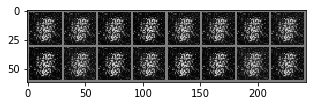

1.4901316165924072
Epoch 1/9
----------
Epoch: 1, D: 0.8813, G:1.516


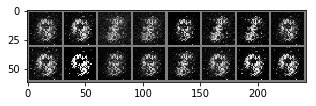

0.8812961578369141
Epoch 2/9
----------
Epoch: 2, D: 0.9291, G:2.707


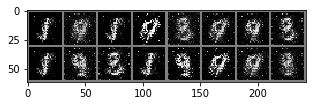

0.9290977120399475
Epoch 3/9
----------
Epoch: 3, D: 0.7677, G:1.441


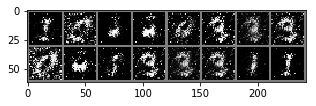

0.7677463889122009
Epoch 4/9
----------
Epoch: 4, D: 1.007, G:1.124


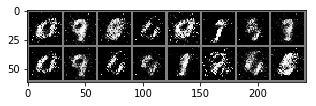

1.007293701171875
Epoch 5/9
----------
Epoch: 5, D: 0.7791, G:1.8


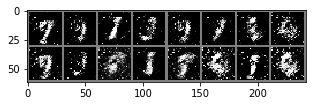

0.7791314721107483
Epoch 6/9
----------
Epoch: 6, D: 1.102, G:2.422


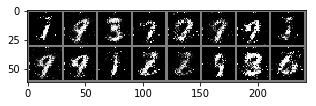

1.102118730545044
Epoch 7/9
----------
Epoch: 7, D: 1.068, G:1.578


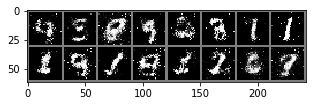

1.0680394172668457
Epoch 8/9
----------
Epoch: 8, D: 1.052, G:1.324


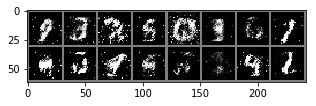

1.0516082048416138
Epoch 9/9
----------
Epoch: 9, D: 1.356, G:0.6013


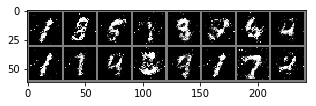

1.356039047241211
Training complete in 1m 41s


In [141]:
D, G = train_model(D, G, discriminator_loss, generator_loss, D_optimizer, G_optimizer, noise_size=96, num_epochs=10)